In [1]:
from build.thermal_conduction import ThermalConduction
from pod import POD
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import torch
import random
from tqdm import tqdm
import time

random.seed(100)

# POD on thermal problem

This notebook contains the report valid for the exam of Computational Mechanics with ROM. The goal of the project is to implement efficient Reduced order method strategies to approximate the solution of different steady state thermal problems. The dataset presented in this work have been generated using deal.II library v$9.6.2$.

## Problem formulation

The heat equation considered throughout this work is:

$$
\begin{cases}
k \nabla u = 0 & \text{in } \Omega, \
u = 0 & \text{on } \partial \Omega_{1,2}, \
u = T_{bc} & \text{on } \partial \Omega_3,
\end{cases}
$$

We consider a two-dimensional rectangular domain $\Omega = [0,3] \times [0,6]$. The computational grid is globally refined 7 times, resulting in approximately $16000$ cells. The figure below illustrates the domain:

<div style="text-align: center;">
    <img src="img/domain.png" alt="Domain" width="250px" />
</div>

We considered three different scenarios, in which we vary parameters that affect the structure and material distribution within the domain. All simulations are conducted using first-order Continuous Galerkin Finite Element Method (CG FEM).

### Problem 1

The first and simplest scenario consists of a single material with fixed thermal conductivity $\mu = 1$ and a variable boundary temperature applied on $\partial \Omega_3$. Specifically, the temperature is varied from a minimum of $10,\text{K}$ to a maximum of $1000,\text{K}$. The figure below graphically illustrates this scenario:

<div style="text-align: center;">
    <img src="img/formulation_1.png" alt="Domain" width="150px" />
</div>

### Problem 2

In this scenario, we consider a block composed of three vertical strips made of different materials, each with a distinct thermal conductivity. The boundary temperature on $\partial \Omega_3$ is fixed and set to $500,\text{K}$. The figure below graphically illustrates this configuration:

<div style="text-align: center;">
    <img src="img/formulation_2.png" alt="Domain" width="150px" />
</div>

### Problem 3

This is the most complex scenario considered in this work. Specifically, we define a block composed of three different materials stacked horizontally. The thermal conductivities of the materials are fixed throughout the simulations and are set to $20.0$, $10.0$, and $1.0$, respectively. We vary the height of each layer: the first material has a height ranging from $0.5$ to $3.25$. The second material is stacked on top of the first, with its height varying such that the combined height of the first two layers remains below $5.5$. Finally, the third material is placed on top of the second, extending the total height of the structure up to a maximum of $6.0$. Moreover, the temperature applied to the bottom boundary varies from a minimum of $100K$ to a maximum of $1000K$

<div style="text-align: center;">
    <img src="img/formulation_3.png" alt="Domain" width="170px" />
</div>

# Implementation details 

All simulations are conducted in Python notebooks, using the deal.II library as a backend.

The core problem is implemented in C++ and exposed to Python via Pybind11 bindings. This C++ class defines the thermal conduction problem and is responsible for computing the system matrix and right-hand side, including their affine decompositions when applicable. These components are accessed by the Python code for further processing.

The POD class, written in Python, manages the entire reduced order model pipeline—from constructing the reduced basis to projecting the solution back into the original space. It relies on the problem class for system data (either affine components or the full system) and uses the PyTorch library to handle matrix operations and perform the Singular Value Decomposition (SVD).

In [2]:
# This block contains additional function useful for splitting data, 
# computing errors and plotting results

def split_data(simulations, parameters, train_size=0.8):
    """
    Split dataset in train and test subsets. 
    
    Args:
        simulations (torch.Tensor): 2D tensor of size (NxN_dofs) containing 
            snapshots.
        parameters (torch.Tensor): 2D tensor of size (NxN_params) containing 
            parameters.
        train_size (float): percentage of elements in the training set.

    Returns:
        tuple(torch.Tensor): Splitting of snapshot and parameters in train and 
            test datasets
    """
    train_size = int(len(parameters) * train_size)
    p_train = parameters[:train_size]
    u_train = simulations[:train_size]
    
    p_test = parameters[train_size:]
    u_test = simulations[train_size:]
    return p_train, u_train, p_test, u_test

def compute_L2_error(u_true, u_pred):
    """
    Compute the L2 error given ground truth and predictions

    Args:
        u_true (torch.Tensor): 2D tensor of size (NxN_dofs) containing ground
            truth.
        u_true (torch.Tensor): 2D tensor of size (NxN_dofs) containing 
            predictions.

    Returns:
        float: The L2 error
    """
    return torch.linalg.norm(u_true - u_pred) / torch.linalg.norm(u_true)
    
def plot_singular_values(singular_values):
    """
    Plot normalized singular values.
    
    Args:
        singular_values (torch.Tensor): Singualar value coming from POD on 
            snapshots
    """
    singular_values = singular_values / singular_values[0]
    plt.semilogy(singular_values, marker='o')    

def plot_comparison(u_pred, u_true, x, y):
    """
    Plot the prediction and the ground truth

    Args:
        u_pred (torch.Tensor): 1D tensor of shape (N_dofs) containing the 
            prediction.
        u_true (torch.Tensor): 1D tensor of shape (N_dofs) containing the 
            ground truth.
        x (torch.Tensor): 1D tensor of shape (N_dofs) containing the x 
            coordinates
        y (torch.Tensor): 1D tensor of shape (N_dofs) containing the y
            coordinates
    """
    tria = Triangulation(x, y)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))

    diff = torch.abs(u_pred - u_true)
    
    levels_main = torch.linspace(0, u_pred.max().item(), steps=100)
    levels_diff = torch.linspace(0, diff.max().item(), steps=100)
    
    # Plot predicted solution
    ax[0].set_title("POD")
    tcf0 = ax[0].tricontourf(tria, u_pred, cmap='jet', levels=levels_main)
    fig.colorbar(tcf0, ax=ax[0])

    levels_main = torch.linspace(0, u_true.max().item(), steps=100)
    # Plot true solution
    ax[1].set_title("True")
    tcf1 = ax[1].tricontourf(tria, u_true, cmap='jet', levels=levels_main)
    fig.colorbar(tcf1, ax=ax[1])
    
    # Plot difference between true and predicted solutions
    ax[2].set_title("Difference")
    tcf2 = ax[2].tricontourf(tria, diff, cmap='jet', levels=levels_diff)
    fig.colorbar(tcf2, ax=ax[2])

In general, the POD procedure consists of two main phases: the offline phase, which is the most computationally expensive, and the online phase, which is significantly lighter. The offline phase consists of the following steps:

1. Generate several snapshots from high-fidelity simulations.
2. Apply Singular Value Decomposition (SVD) to the snapshot matrix. This step yields three matrices:
  $$
  U \in \mathbb{R}^{N_{\text{dofs}} \times N_{\text{dofs}}},\quad
  \Sigma \in \mathbb{R}^{N_{\text{dofs}} \times N},\quad
  V \in \mathbb{R}^{N \times N}
  $$
  where $\Sigma$ is a diagonal matrix whose diagonal entries are the singular values.

3. Inspect the decay of the singular values to identify an "elbow" in the plot. This helps determine the number of modes needed to construct an accurate reduced basis.
4. Select $N_{\text{basis}}$, the number of basis vectors to retain, and construct the reduced basis by taking the first $N_{\text{basis}}$ columns of the matrix $U$.
5. Apply affine decomposition. In this case we can rewrite the full rank system matrix $A$ as
  $$
  A = \sum_{i=1}^q \theta_q(\mu_q) A_q \;\;\; \text{   and   } \;\;\; f = \sum_{i=1}^q \theta_q(\mu_q) f_q
  $$
  where $A_q \in \mathbb{R}^{N_{\text{dofs}}\times N_{\text{dofs}}}$ and $f_q \in \mathbb{R}^{N_{\text{dofs}}}$
  
6. Project $A_q$ and $f_q$ onto the reduced space:
   $$
   A_q^r = \tilde{U}^\top A_q \tilde{U}, \quad f_q^r = \tilde{U}^\top f_q
   $$

   where $A_q^r \in \mathbb{R}^{N_{\text{basis}} \times N_{\text{basis}}}$ and $f_q^r \in \mathbb{R}^{N_{\text{basis}}}$.

The online phase consists of:

1. Assembling the reduced-order system:

   $$
   A^r = \sum_{i=1}^q \theta_i(\mu) A_i^r, \quad f^r = \sum_{i=1}^q \theta_i(\mu) f_i^r
   $$

2. Solving the reduced system for $u^r \in \mathbb{R}^{N_{\text{basis}}}$:
   $$
   A^r u^r = f^r
   $$

3. Reconstructing the full-order solution:
   $$
   u = \tilde{U} u^r
   $$

If affine decomposition is not applicable, then in the online phase we must assemble the full-order system matrix and right-hand side for each new parameter configuration and project them onto the reduced space. This substantially increases the computational cost, defeating the efficiency advantage of the reduced model.

To generate the data, we use the Finite Element Method (FEM), starting by defining the weak formulation of the problem. Let $\mu$ denote the bottom boundary temperature, which serves as our parametric input. The parametric weak formulation reads:

$$
a(u, v; \mu) = f(v; \mu) \quad \forall v \in \mathbb{V} = \left\{ v \in H^1(\Omega) \,\middle|\, v|_{\partial \Omega_D} = 0 \right\},
$$

where:

- $u \in \mathbb{U} = \left\{ w \in H^1(\Omega) \,\middle|\, w|_{\partial \Omega} = g(\mu) \right\}$ is the trial space with nonhomogeneous Dirichlet boundary conditions,
- $g(\mu)$ is the boundary function, which depends on the parameter $\mu$ (the temperature),
- $a(u, v; \mu) = \int_\Omega \nabla u \cdot \nabla v \, dx$ is the bilinear form,
- $f(v; \mu) = 0$ is the linear form (homogeneous right-hand side).

Given this formulation, we compute the high-fidelity full-order solution using the **deal.II** library.

### Problem 1

For this simplest scenario, we applied a basic Proper Orthogonal Decomposition (POD) strategy. The problem depends on a single parameter: the temperature prescribed on the bottom boundary. We sampled $500$ different values uniformly in the range $[10, 1000]$ and performed a simulation for each value.

In [3]:
# Define problem
regions = []
conductivities = [1.0]
axis = 0
boundary_temperatures = [0.0, 0.0, 1.0, -1.0]
problem = ThermalConduction(regions=regions, 
                            conductivities=conductivities,
                            axis=axis,
                            boundary_temperatures=boundary_temperatures
                           )

# Sample temperatures
min_, max_ = 10, 1000
temperatures = [random.uniform(min_, max_) for _ in range(500)]

# Perform simulation


def simulate(temperatures):
    simulations= []
    boundary_temperatures = [0,0,1,-1]
    for temperature in tqdm(temperatures):
        boundary_temperatures[2] = temperature
        problem.set_boundary_temperatures(boundary_temperatures)
        simulations.append(problem.solve_system())
    return simulations

To understand the computational time gain between the high-fidelity FEM solution and the POD-reduced model, let’s compute the per-simulation time:

In [4]:
start = time.time()
simulations = simulate(temperatures)
elapsed_time = time.time() - start
per_sim_time = elapsed_time / 500

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.61it/s]


Then you aim to apply POD on the generated snapshot. In generaral the POD procedure involves the following steps:

The code block below uses the snapshots computed in deal.II and performs a Singular Value Decomposition (SVD) to generate a suitable reduced basis. First, based on the singular values, we aim to determine the appropriate number of basis vectors:

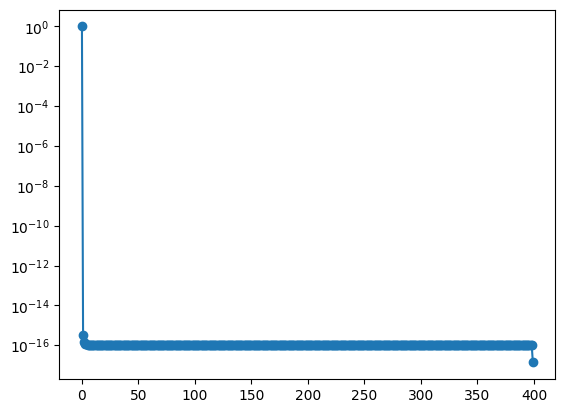

In [5]:
# Data casting and splitting
simulations, parameters = (
    torch.tensor(np.array(simulations), dtype=torch.float64), 
    torch.tensor(temperatures, dtype=torch.float64).unsqueeze(-1)
)
p_train, u_train, p_test, u_test = split_data(simulations, parameters)

# Plotting singular values
pod = POD(len(p_train), problem)
pod.fit(u_train)
plot_singular_values(pod.singular_values)

As expected, the appropriate number of basis functions is $1$. This is not surprising, since the only parameter we vary in this scenario is the bottom boundary temperature.

In this case, the affine decomposition is trivial. Specifically, the system matrix remains constant and the only thing that changes in the rhs:

$$
f(\mu) = \mu f_q,
$$

where $A_q$ is a parameter-independent matrix. This simple affine structure allows us to efficiently apply the reduced-order model during the online phase.

In [6]:
problem.set_boundary_temperatures([0.0, 0.0, 1.0, -1.0])

start = time.time()
pod = POD(1, problem, fixed_stiffness=True)
pod.fit(u_train)
offline_time = time.time() - start

start = time.time()
u_pred = pod.predict(p_test)
elapsed_time = time.time() - start
per_it_online = elapsed_time / 100

POD L2 error: 1.2922e-15


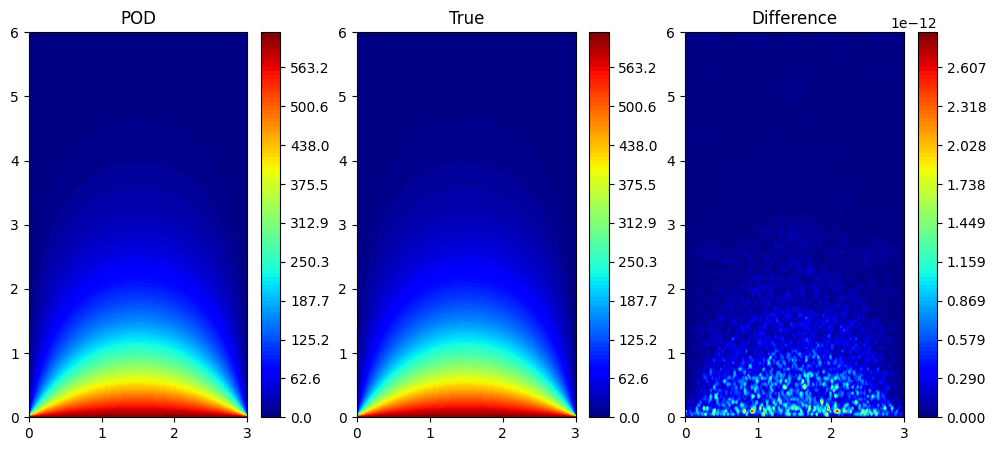

In [7]:
plot_comparison(u_pred[20], u_test[20], pod.x, pod.y)
print(f"POD L2 error: {compute_L2_error(u_test, u_pred):.4e}")

The error is very low; hence, we can conclude that a POD with a single basis vector is able to accurately approximate the high-fidelity solution.

In [8]:
print(f"Simulation time: {per_sim_time} s/it")
print(f"Prediction time: {per_it_online} s/it")
print(f"Projection time: {offline_time} s")

Simulation time: 0.033773195266723635 s/it
Prediction time: 4.490375518798828e-05 s/it
Projection time: 0.17085886001586914 s


From the time measurements, we observe a significant reduction in computational time for a single simulation. Moreover, both the SVD and the projection onto the reduced space are not computationally expensive.

# Problem 2

In this second test case, the parameters correspond to the conductivities of the three vertical strips, denoted by $\mu = (\mu_1, \mu_2, \mu_3)$. A total of 500 configurations are generated by independently sampling each parameter from the uniform distribution $\mathcal{U}(0.1, 10)$.

Also in this case, the affine decomposition is straightforward: since the only variations in the domain are the conductivity coefficients of the three strips, we can construct three different affine system matrices such that:

$$
A = \sum_{i=1}^3 \mu_i A_i
$$

The following block of code sets up the problem for performing simulations in this second setting:

In [9]:
# Define problem
regions = [1.0, 2.0]
conductivities = [1.0, 1.0, 1.0]
axis = 0
boundary_temperatures = [0.0, 0.0, 500.0, -1.0]
problem = ThermalConduction(regions=regions, 
                            conductivities=conductivities,
                            axis=axis,
                            boundary_temperatures=boundary_temperatures
                           )

# Sample temperatures
min_, max_ = 0.1, 10
conductivities = [[random.uniform(min_, max_) for _ in range(len(conductivities))] for _ in range(500)]

def simulate(conductivities):
    simulations= []
    for conductivity in tqdm(conductivities):
        problem.set_conductivities(conductivity)
        simulations.append(problem.solve_system())
    return simulations

In [10]:
# Perform simulation
start = time.time()
simulations = simulate(conductivities)
elapsed_time = time.time() - start
per_sim_time = elapsed_time / 500

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.92it/s]


We now have the simulations! Lets now plot the singular values to understand how many of them are necessary for a good POD approximation

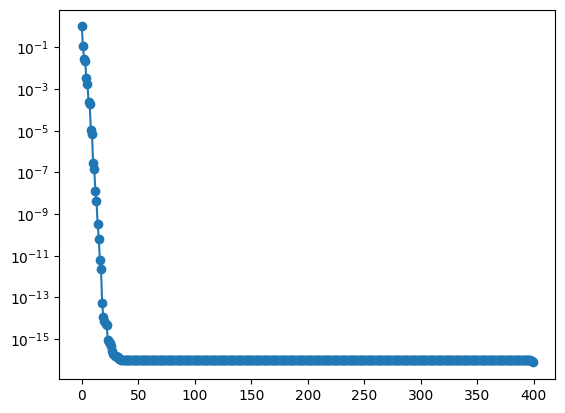

In [11]:
# Data casting and splitting
simulations, parameters = (
    torch.tensor(np.array(simulations), dtype=torch.float64), 
    torch.tensor(conductivities, dtype=torch.float64)
)
p_train, u_train, p_test, u_test = split_data(simulations, parameters)

# Plotting singular values
pod = POD(len(p_train), problem)
pod.fit(u_train)
plot_singular_values(pod.singular_values)

From the plot above we can see that a suitable number of modes is around $20$. The following block of code fits a POD for several modes number and it compute the $L2$ error of the predictions:

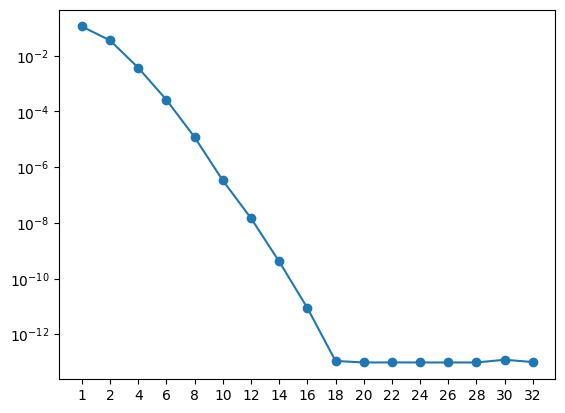

In [12]:
problem.set_conductivities([1.0,1.0,1.0])
n_modes = [i * 2 for i in range(1,17)]
n_modes.insert(0, 1)
L2_errors = []
for n in n_modes:
    pod = POD(n, problem)
    pod.fit(u_train)
    u_pred = pod.predict(p_test)
    L2_errors.append(compute_L2_error(u_test, u_pred))

plt.semilogy(L2_errors, marker='o')
_ = plt.xticks([i for i in range(len(n_modes))], n_modes)

From the plot above we can see that the error stop deacreasing from a number of $18$ modes. 

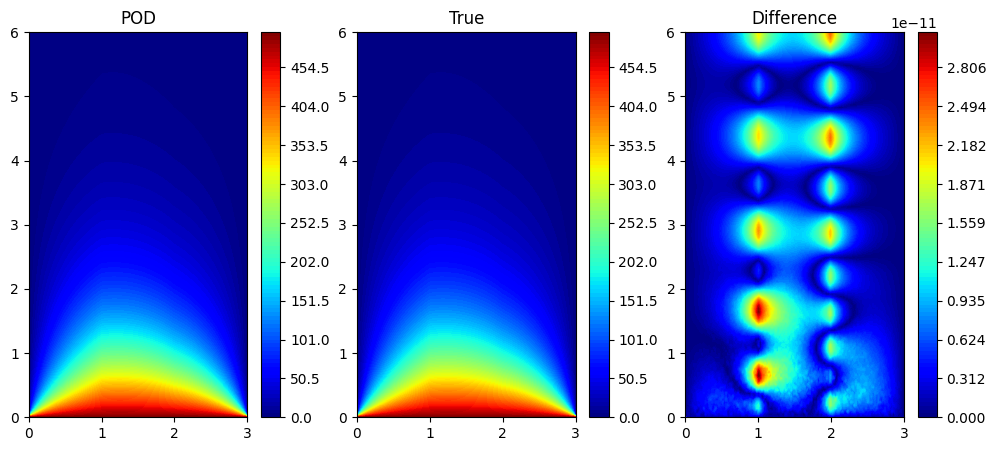

In [13]:
start = time.time()
pod = POD(18, problem)
pod.fit(u_train)
offline_time = time.time() - start

start = time.time()
u_pred = pod.predict(p_test)
elapsed_time = time.time() - start
per_it_online = elapsed_time / 100
plot_comparison(u_pred[20], u_test[20], pod.x, pod.y)

In [14]:
print(f"Simulation time: {per_sim_time} s/it")
print(f"Prediction time: {per_it_online} s/it")
print(f"Projection time: {offline_time} s")

Simulation time: 0.0528463888168335 s/it
Prediction time: 8.006572723388672e-05 s/it
Projection time: 0.20311570167541504 s


Also in this case, from the time measurements, we observe a significant reduction in computational time for a single simulation. However, both the simulation time and the online prediction time using POD are higher than in the previous case.

# Problem 3

This is the last and most complex scenario considered in this work. The upper boundary of the first region is sampled from the uniform distribution $\mathcal{U}(0.5, 3.25)$, while that of the second region is sampled from $\mathcal{U}(3.75, 5.5)$. Additionally, the bottom boundary temperature is sampled from $\mathcal{U}(100, 1000)$.

Note that, since the geometry of the domain varies across samples, an affine decomposition is not possible in this scenario.

In [15]:
# Define problem
regions = [2.0, 4.0]
conductivities = [20.0, 10.0, 1.0]
problem.set_regions(regions)
problem.set_conductivities(conductivities)
problem.set_axis(1)
problem.set_boundary_temperatures([0.0, 0.0, 1.0, -1.0])

# Sample temperatures
min_, max_ = [.5, 3.75], [3.25, 5.5]
regions = [[random.uniform(min_[i], max_[i]) for i in range(len(regions))] for _ in range(500)]
min_, max_ = 100, 1000
temperatures = [random.uniform(min_, max_) for _ in range(500)]


def simulate(regions, temperatures):
    simulations= []
    boundary_temperatures = [0,0,1,-1]
    parameters = []
    for r, t in tqdm(zip(regions, temperatures), total=len(regions)):
        problem.set_regions(r)
        boundary_temperatures[2] = t
        parameters.append([r[0], r[1], t])
        problem.set_boundary_temperatures(boundary_temperatures)
        simulations.append(problem.solve_system())
    return simulations, np.array(parameters)

In [16]:
# Perform simulation
start = time.time()
simulations, parameters = simulate(regions, temperatures)
elapsed_time = time.time() - start
per_sim_time = elapsed_time / 500

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.76it/s]


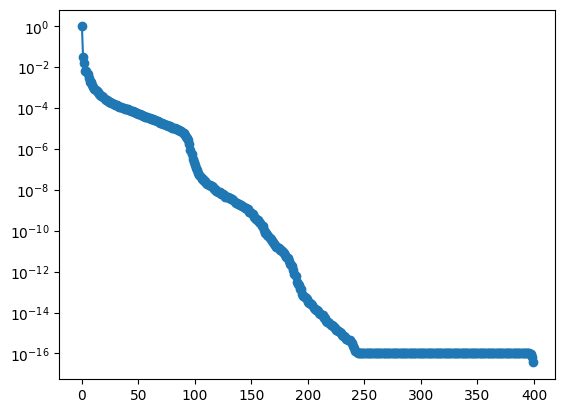

In [17]:
# Data casting and splitting
simulations, parameters = (
    torch.tensor(np.array(simulations), dtype=torch.float64), 
    torch.tensor(parameters, dtype=torch.float64)
)
p_train, u_train, p_test, u_test = split_data(simulations, parameters)

# Plotting singular values
pod = POD(len(p_train), problem, affine=False) # No affine decomposition is performed
pod.fit(u_train)
plot_singular_values(pod.singular_values)

From the plot above, we observe that the decay of the singular values is significantly slower than in the previous scenarios. Indeed, in this case, $250$ modes are required to capture the majority of the system’s energy.

As done in the previous scenario, we fit a POD for several modes number and it compute the $L2$ error of the predictions:

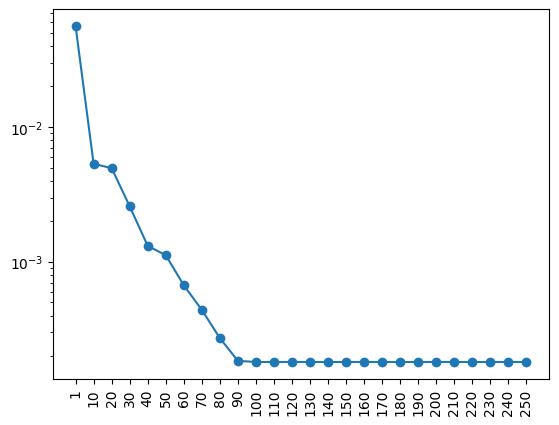

In [18]:
n_modes = [i * 10 for i in range(1,26)]
n_modes.insert(0, 1)
L2_errors = []
for n in n_modes:
    pod = POD(n, problem, affine=False)
    pod.fit(u_train)
    u_pred = pod.predict(p_test)
    L2_errors.append(compute_L2_error(u_test, u_pred))

plt.semilogy(L2_errors, marker='o')
_ = plt.xticks([i for i in range(len(n_modes))], n_modes, rotation=90)

We can see that the overall error that we can achive is much higher than the one of the previous cases!

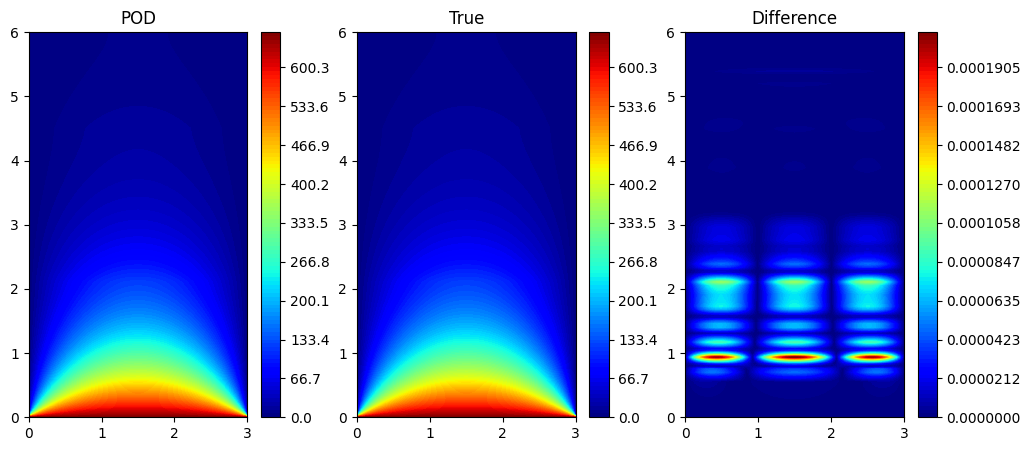

In [19]:
n = 100
start = time.time()
pod = POD(n, problem, affine=False)
pod.fit(u_train)
offline_time = time.time() - start

start = time.time()
u_pred = pod.predict(p_test)
elapsed_time = time.time() - start
per_it_online = elapsed_time / 100
plot_comparison(u_pred[0], u_test[0], pod.x, pod.y)

In [20]:
print(f"Simulation time: {per_sim_time} s/it")
print(f"Prediction time: {per_it_online} s/it")
print(f"Projection time: {offline_time} s")

Simulation time: 0.05629551935195923 s/it
Prediction time: 0.04527026414871216 s/it
Projection time: 0.1380753517150879 s


From the results, we observe that the computational time of POD is of the same order of magnitude as that required to build a high-fidelity simulation using FEM. To address this issue, a possible solution could involve more sophisticated methods such as POD-RBF or POD-NN.